#### 분류평가
- 정확도만으로 불균형한 레이블 데이터 세트에서 평가 지표로 사용하기에는 부적합  
- 정확도가 가지는 분류 평가 지표로의 한계점을 극복하기 위해 여러가지 분류 지표와 함께 적용해야 함  

#### Confusion Matrix(혼동행렬, 오차행렬)
- 이진분류에서 성능지표로 잘 활용되는 오차행렬은 학습된 분류 모델이 예측을 수행하면 얼마나 혼동될 수 있는지도 함께 보여주는 지표  
- 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 보여줌

#### 평가 지표
- TP, FP, FN, TN는 예측클래스와 실제 클래스의 Positive 결정 값과 Negative 결정 값의 결합에 따라 결정
- 앞문자 True/False는 예측값과 실제값이 같은가/틀린가를 의미하고 뒤 문자 N/P는 예측 결과값이 부정/긍정을 의미  
- 정확도 = (TP + TN) / (TP + TN + FP + FN)  
- 정밀도 = TP / (TP + FP) : P로 예측한 것중에서 실제도 P
- 재현율 = TP / (TP + FN) : 실제 P인 것중에서 예측도 P
- F1 = 2 * ((정밀도 * 재현율) / (정밀도 + 재현율)) : 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 높아짐
- 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
- 재현율이 중요 지표인 경우 : 양성데이터를 음성으로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(암진단, 보험사기)
- 정밀도가 더 중요한 지표인 사례 : 스팸메일 여부를 판단하는 경우로 스팸메일이 아닌데 스팸메일로 분류해서 업무 차질 발생

#### 정밀도 및 재현율 활용 시 유의사항
- 정밀도와 재현율 성능 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능
- 정밀도 100%가 되는 방법 : 확실한 기준이 되는 경우만 P로 예측하고 나머지는 모두 N으로 예측 TP / (TP + FP) = 1 / (1 + 0) = 1
- 재현율이 100%가 되는 방법 : 실제 양성 1000명 중 30명 TP / (TP + FN) = 30 / (30 + 0) = 1
- 분류가 정밀도, 재현율 중 하나에 상대적인 중요도를 부여할 수 있지만 하나만 강조해서는 안됨.
- 암 예측 모델에서 재현율을 높인다고 주로 양성만 판정한다면 환자의 불만과 불평이 커지게 됨

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [49]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def fillnas(df):
    def callname(x):
        m = re.compile('[A-Za-z]+[.]')
        p = re.findall(m,x)
        return p[0]
    
    df['Callname']=df.Name.apply(lambda x:callname(x))
    
    df1 = df.loc[df.Age.isnull()]
    age_nulllist = list(set(df1.Callname.values.tolist()))
    
    df2 = df.loc[df.Age.notnull()]
    pivot = pd.pivot_table(df2, index = 'Callname', values = 'Age',aggfunc = 'mean')
    
    for age in age_nulllist:
        df.loc[(df.Age.isnull())&(df.Callname == age),['Age']]=(pivot.loc[age][0])
        
    df['Embarked'].fillna(method = 'ffill',inplace=True)
    
    df3 = df.loc[df.Cabin.notnull()]

    df3['Cabins'] = df3['Cabin'].str[:1]
    df4 = df.loc[df.Cabin.isnull()]
    
    for i in range(1,4):
        df33 = df3.loc[df3.Pclass == i]
        cabin_fill_list=list(set(df33.Cabins.values.tolist()))
        df44 = df4.loc[df4.Pclass == i]
        fill_index = list(df44.index)
        for index in fill_index:
            df.loc[index,'Cabin'] = np.random.choice(cabin_fill_list)
            
    return df

# 불필요 항목 제거
def drop_feat(df):
    df.drop(['PassengerId','Name','Ticket','Callname'],axis=1,inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    scaler = MinMaxScaler()
    scaler.fit(df[['Fare']])
    fare_scaled = scaler.transform(df[['Fare']])
    df['Fare'] = fare_scaled
    
    return df

def transform_features(df):
    df = fillnas(df)
    df = drop_feat(df)
    df = format_features(df)
    return df

In [50]:
import pandas as pd
t_df = pd.read_csv('../m6_머신러닝알고리즘이해및활용/dataset/train.csv')
y_t_df = t_df['Survived']
X_t_df = t_df.drop('Survived',axis=1)
X_t_df = transform_features(X_t_df)
X_t_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,0.014151,4,2
1,1,0,38.0,1,0,0.139136,2,0
2,3,0,26.0,0,0,0.015469,4,2
3,1,0,35.0,1,0,0.103644,2,2
4,3,1,35.0,0,0,0.015713,4,2


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_t_df, y_t_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541


In [52]:
confusion = confusion_matrix(y_test, pred)
confusion

array([[109,   9],
       [ 15,  46]], dtype=int64)

In [53]:
confusion = confusion_matrix(y_test, pred)
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
TP = confusion[1,1]
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('정확도: ',round(accuracy,4))
print('정밀도: ',round(precision,4))
print('재현율: ',round(recall,4))
print('F1 Score: ',round(2 * ((precision * recall) / (precision + recall)),4))

정확도:  0.8659
정밀도:  0.8364
재현율:  0.7541
F1 Score:  0.7931


In [54]:
# precision, recall은 Trade-off 관계
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])


pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.54105804 0.45894196]
 [0.8803147  0.1196853 ]
 [0.88470057 0.11529943]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.54105804 0.45894196 0.        ]
 [0.8803147  0.1196853  0.        ]
 [0.88470057 0.11529943 0.        ]]


In [62]:
pred_proba[:,1]

array([0.45894196, 0.1196853 , 0.11529943, 0.13605457, 0.16564869,
       0.13019295, 0.09906698, 0.78334316, 0.24753616, 0.65046249,
       0.11007263, 0.12249253, 0.11530632, 0.10054496, 0.48005325,
       0.14008895, 0.09111711, 0.29877732, 0.28533982, 0.83137657,
       0.27925367, 0.35937798, 0.14464411, 0.19099652, 0.0995235 ,
       0.24703111, 0.15368842, 0.06733739, 0.31767836, 0.3167265 ,
       0.91797715, 0.78701643, 0.12786126, 0.82388858, 0.37303837,
       0.24408785, 0.07048998, 0.59220959, 0.05006227, 0.10175019,
       0.39559203, 0.08207282, 0.80977095, 0.72485952, 0.69265725,
       0.69267536, 0.89868047, 0.35042203, 0.94749395, 0.09956137,
       0.48522799, 0.09770764, 0.12795563, 0.72611459, 0.34642449,
       0.19861881, 0.23131239, 0.11858168, 0.15383395, 0.48064374,
       0.31386548, 0.09912632, 0.48938459, 0.57366623, 0.36360928,
       0.08958348, 0.64636456, 0.57251589, 0.94951076, 0.13556714,
       0.12475625, 0.16874534, 0.10175286, 0.93796067, 0.21937

In [63]:
pred_proba[[1]]

array([[0.8803147, 0.1196853]])

In [8]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [9]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임.  
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼 , 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[106  12]
 [ 14  47]]
정확도: 0.8547, 정밀도: 0.7966, 재현율: 0.7705


In [10]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[98 20]
 [ 9 52]]
정확도: 0.8380, 정밀도: 0.7222, 재현율: 0.8525


In [11]:
pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1], dtype=int64)

In [12]:
pred_proba[:,1].shape

(179,)

In [13]:
# Q. 임계값을 [0.4, 0.45, 0.50, 0.55, 0.60]로 변경시 각 평가지표의 변화를 출력
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

pred_proba_1 = pred_proba[:,1].reshape(-1,1)
for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
    custom_predict = binarizer.transform(pred_proba_1)
    print('임계값:',custom_threshold)
    get_clf_eval(y_test , custom_predict)
    print()

임계값: 0.4
오차 행렬
[[98 20]
 [ 9 52]]
정확도: 0.8380, 정밀도: 0.7222, 재현율: 0.8525

임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033

임계값: 0.5
오차 행렬
[[106  12]
 [ 14  47]]
정확도: 0.8547, 정밀도: 0.7966, 재현율: 0.7705

임계값: 0.55
오차 행렬
[[110   8]
 [ 15  46]]
정확도: 0.8715, 정밀도: 0.8519, 재현율: 0.7541

임계값: 0.6
오차 행렬
[[112   6]
 [ 17  44]]
정확도: 0.8715, 정밀도: 0.8800, 재현율: 0.7213



In [14]:
# [과제] 임계값을 0~1로 변경시킬 때 precision과 recall 변화 추세를 시각화하여 출력
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [15]:
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba[:,1])
precisions[0], recalls[0], thresholds[0]

(0.4206896551724138, 1.0, 0.10229796506195632)

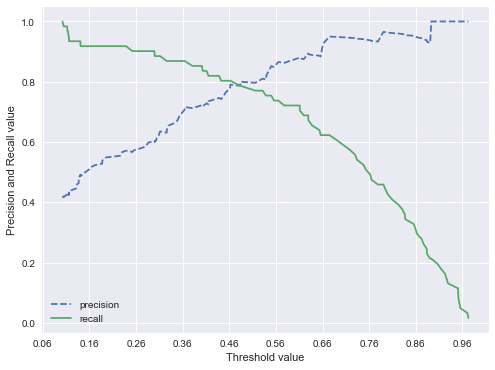

In [16]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    plt.style.use('seaborn')
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )


In [17]:
# F1 Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
f1

0.7833333333333333

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, f1_Score: {3:.4f}'.format(accuracy , precision ,recall,f1))

In [19]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

pred_proba = lr_clf.predict_proba(X_test)
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
    custom_predict = binarizer.transform(pred_proba_1)
    print('임계값:',custom_threshold)
    get_clf_eval(y_test , custom_predict)
    print()


임계값: 0.4
오차 행렬
[[98 20]
 [ 9 52]]
정확도: 0.8380, 정밀도: 0.7222, 재현율: 0.8525, F1:0.7820

임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840

임계값: 0.5
오차 행렬
[[106  12]
 [ 14  47]]
정확도: 0.8547, 정밀도: 0.7966, 재현율: 0.7705, F1:0.7833

임계값: 0.55
오차 행렬
[[110   8]
 [ 15  46]]
정확도: 0.8715, 정밀도: 0.8519, 재현율: 0.7541, F1:0.8000

임계값: 0.6
오차 행렬
[[112   6]
 [ 17  44]]
정확도: 0.8715, 정밀도: 0.8800, 재현율: 0.7213, F1:0.7928



#### ROC Curve와 AUC
- 수신자 판단 곡선이라고 하여 ML의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표
- FPR이 변할 때 TPR이 어떻게 변하는지을 나타내는 곡선으로 FPR = 1- TNR(특이점) TPR은 재현율(민감도)를 나타냄
- TNR = TN / (FP + TN)이며 FPR은 FP / (FP + TN)
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화하는 값을 구한 곡선이다.
- FPR을 0에서 1까지 변경하는 것은 P 예측값을 결정하는 기준인 분류 결정 임계값을 변경하면 됨
- FPR을 0으로 만드려면 임계값을 1로 지정하고 반대로 FPR을 1로 만드려면 임계값을 0으로 지정

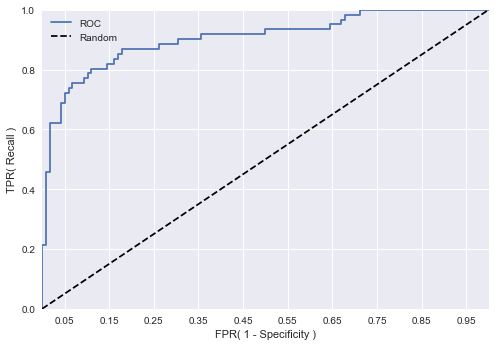

In [20]:
from sklearn.metrics import roc_curve
plt.style.use('seaborn')

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Specificity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, pred_proba_class1 )

In [21]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9053


In [22]:
def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [23]:
get_clf_eval(y_test,pred,pred_proba)

오차 행렬
[[106  12]
 [ 14  47]]
정확도: 0.8547, 정밀도: 0.7966, 재현율: 0.7705, F1: 0.7833, AUC:0.9053


[과제] train.csv 파일을 불러와서 분류모델링 평가를 아래와 같이 수행하세요.
- dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
- accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가


In [24]:
import pandas as pd

t_df = pd.read_csv('../m6_머신러닝알고리즘이해및활용/dataset/train.csv')

# 전처리
def preprocessing1(t):
    df = t.copy()
    
    # ------컬럼 재정비------
    # 동반자를 Family
    df['Family'] = t.SibSp + t.Parch
    # Name feature에서 Title만 뽑아 다시 넣음
    df['Name'] = df['Name'].apply(lambda x: x.split(", ", 1)[1].split(".")[0])
    
    # ------결측치 처리------
    # Age 결측치 처리 : Title 넣어놓은 Name의 평균으로 결측치 대체
    for i in df.Name:
        df.Age[(df.Name == i)&(df.Age.isnull())] = df.Age[df.Name == i].mean()
    # Embarked 결측치 처리 : 최빈값으로 대체
    many = df.Embarked.value_counts().index[0]
    df.Embarked = df.Embarked.fillna(many)
    # Cabin 결측치 처리 :
    # 결측 데이터를 pcalss 별로 'X','Y','Z'로 부여
    df.loc[(df.Pclass == 1)&(df.Cabin.isnull()),'Cabin'] = 'X'
    df.loc[(df.Pclass == 2)&(df.Cabin.isnull()),'Cabin'] = 'Y'
    df.loc[(df.Pclass == 3)&(df.Cabin.isnull()),'Cabin'] = 'Z'
    # Cabin의 첫 번째 문자를 추출해 대표로 함.
    df['Cabin'] = df['Cabin'].apply(lambda x: x[0])
    
    # ------숫자 컬럼들 표준화 및 카테고리화------
    # zscore가 minmaxscale보다 이상치에 영향이 적다고 함
    df.Fare = df.Fare.apply(lambda x: (x - df.Fare.mean()) / df.Fare.std())
    df.Age = df.Age.apply(lambda x: (x - df.Age.mean()) / df.Age.std())

    # 학습에 사용하지 않을 열 삭제
    df.drop(['PassengerId','Ticket','SibSp','Parch','Name'],axis=1,inplace=True)
    
    return pd.get_dummies(df)
pre_df = preprocessing1(t_df)
pre_df.head()

,Survived,Pclass,Age,Fare,Family,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Cabin_Y,Cabin_Z,Embarked_C,Embarked_Q,Embarked_S
0,0,3,-0.584059,-0.502163,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,1,0.621016,0.786404,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1,3,-0.282790,-0.488580,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,1,0.395064,0.420494,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,3,0.395064,-0.486064,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [25]:
from sklearn.model_selection import train_test_split
y_df = pre_df['Survived']
X_df = pre_df.drop('Survived',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_df,y_df,test_size=0.2,random_state=4)

In [26]:
# dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

dt_clf = DecisionTreeClassifier(random_state=25)

parameters = {'max_depth':[10,12,15,18,20],
             'min_samples_split':[2,3,5,7], 'min_samples_leaf':[5,8,12,15]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8244
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8547


In [27]:
# accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

pred = dpredictions
pred_proba = best_dclf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test,pred,pred_proba)

오차 행렬
[[111   8]
 [ 18  42]]
정확도: 0.8547, 정밀도: 0.8400, 재현율: 0.7000, F1: 0.7636, AUC:0.8853


[과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.

- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가
-    ※ 피처 정보  
    'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린), 'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'


- 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임.
- 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생

In [28]:
import pandas as pd
df = pd.read_csv('./dataset/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [30]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [31]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [32]:
# 0인 값들 확인. 이것이 결측치를 의미 
# (pregnancies는 임신을 한 적이 없다는 것을, outcome은 당뇨가 아니라는 것을 의미하므로, 결측치가 아님)
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [33]:
# 함수 사용이 쉽도록 해당 열들을 null로 대체하도 시작
import numpy as np
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [34]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, 'Outcome'),
  Text(0.0, 0, 'Pregnancies'),
  Text(1.0, 0, 'Glucose'),
  Text(2.0, 0, 'BloodPressure'),
  Text(3.0, 0, 'SkinThickness'),
  Text(4.0, 0, 'Insulin'),
  Text(5.0, 0, 'BMI'),
  Text(6.0, 0, 'DiabetesPedigreeFunction'),
  Text(7.0, 0, 'Age'),
  Text(8.0, 0, 'Outcome'),
  Text(9.0, 0, '')])

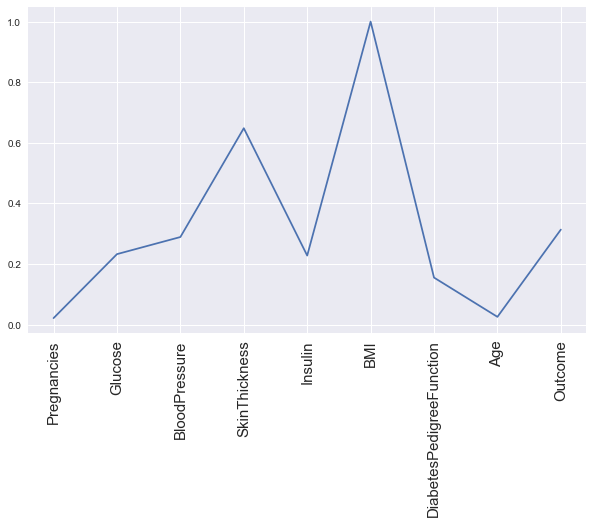

In [35]:
# BMI와 SkinThickness는 비교적 상관 계수가 높아 보임.
# BMI는 비만도이므로, 팔뚝살과 관련이 있을 수 있다.
plt.figure(figsize=(10,6))
df.corr()['BMI'].plot()
plt.xticks(fontsize=15,rotation = 90)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, 'Outcome'),
  Text(0.0, 0, 'Pregnancies'),
  Text(1.0, 0, 'Glucose'),
  Text(2.0, 0, 'BloodPressure'),
  Text(3.0, 0, 'SkinThickness'),
  Text(4.0, 0, 'Insulin'),
  Text(5.0, 0, 'BMI'),
  Text(6.0, 0, 'DiabetesPedigreeFunction'),
  Text(7.0, 0, 'Age'),
  Text(8.0, 0, 'Outcome'),
  Text(9.0, 0, '')])

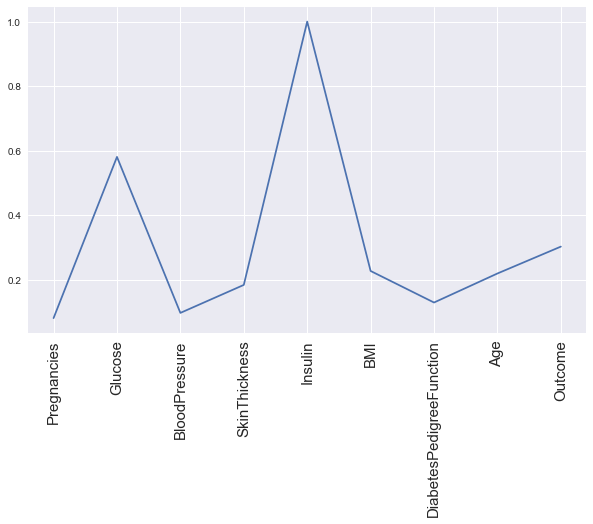

In [36]:
# 당 부하 검사는 포도당을 섭취한 후 운동 후 혈당을 체크해 당 대사 능력을 확인함.
# 인슐린이 부족하면, 혈당이 계속 높은 상태가 된다. 즉, 관계가 있다.
plt.figure(figsize=(10,6))
df.corr()['Insulin'].plot()
plt.xticks(fontsize=15,rotation = 90)

<AxesSubplot:xlabel='Glucose'>

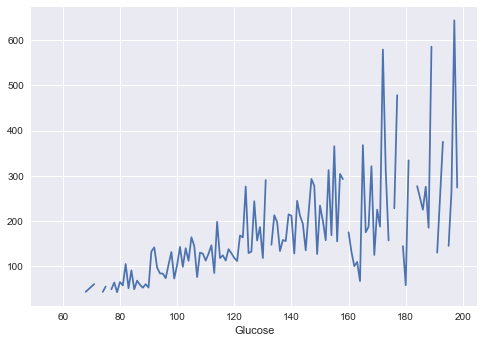

In [37]:
df.groupby(['Glucose']).mean()['Insulin'].plot()

<AxesSubplot:xlabel='Glucose'>

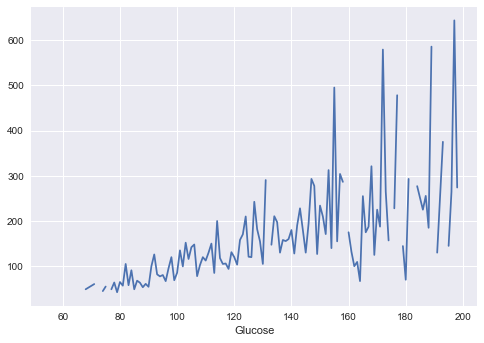

In [38]:
df.groupby(['Glucose']).median()['Insulin'].plot()

In [39]:
def fill_na_1(x):
    return x.fillna(x.median())
df2 = df.copy()
grouped = df2.groupby(['Glucose'])
df2['Insulin'] = grouped['Insulin'].transform(fill_na_1)

<AxesSubplot:xlabel='Glucose'>

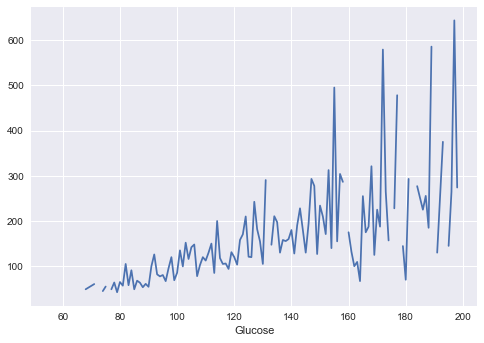

In [40]:
df2.groupby(['Glucose']).median()['Insulin'].plot()

In [41]:
grouped.median().Insulin

Glucose
44.0       NaN
56.0      45.0
57.0       NaN
61.0       NaN
62.0       NaN
         ...  
195.0    145.0
196.0    264.5
197.0    643.5
198.0    274.0
199.0      NaN
Name: Insulin, Length: 135, dtype: float64

In [42]:
def fill_na_1(x):
    return x.fillna(x.median())
df2 = df.copy()
grouped = df2.groupby(['Glucose'])
df2['Insulin'] = grouped['Insulin'].transform(fill_na_1)
df2['Insulin'] = df2['Insulin'].fillna(df2['Insulin'].median())

<AxesSubplot:xlabel='Glucose'>

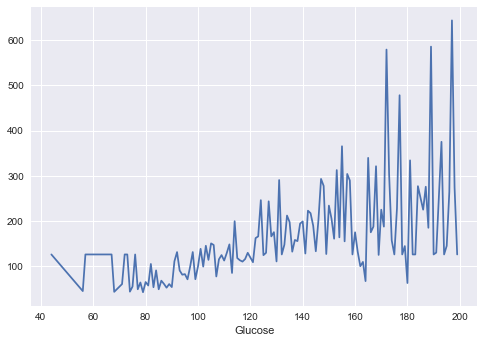

In [43]:
# 결측치 잘 채워지는 것 같은데, 이러면 변수들간의 상관도가 너무 높아지지는 않나?
df2.groupby(['Glucose']).mean()['Insulin'].plot()

In [44]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('./dataset/diabetes.csv')
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

# 결측치 처리 함수
def fill_na_1(x):
    return x.fillna(x.median())

def fill_na_2(t):
    x = t.copy()
    # BMI와 혈압은 평균과 중앙값이 비슷해서 상관 없어 보이나, 조금 더 깔끔해 보여서 중앙값 택함. 이상치에 영향을 덜 받도록 함도 있겠음
    # 통일성을 위해 글루코스도 중앙값으로 대체하였음
    for i in ['Glucose','BloodPressure','BMI']:
        x[i].fillna(x[i].median(), inplace = True)
    # Insulin은 Glucose, Skinthickness는 BMI를 참고하며, 내친김에 Median으로 통일해 보려고 함.
    grouped = x.groupby(['Glucose'])
    x['Insulin'] = grouped['Insulin'].transform(fill_na_1)
    x['Insulin'] = x['Insulin'].fillna(x['Insulin'].median())

    grouped = x.groupby(['BMI'])
    x['SkinThickness'] = grouped['SkinThickness'].transform(fill_na_1)
    x['SkinThickness'] = x['SkinThickness'].fillna(x['SkinThickness'].median())
    return x

def fill_na_3(t):
    x = t.copy()
    # 선생님의 방식대로 전부 평균값으로 대체함
    for i in ['Glucose','BloodPressure','BMI','Insulin','SkinThickness']:
        x[i].fillna(x[i].mean(), inplace = True)
    return x

def scaling(t):
    x = t.copy()
    x_1 = x[['Outcome']]
    x_2 = x.drop(['Outcome'],axis=1)
    scaler = StandardScaler()
    scaler.fit(x_2)
    scaled = scaler.transform(x_2)
    scaled = pd.DataFrame(data=scaled,columns=x_2.columns)
    x = pd.concat([x_1,scaled],axis=1)
    return x


In [45]:
pre_df = scaling(fill_na_2(df))
pre_df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,0.639947,0.866045,-0.031990,0.664110,1.289061,0.166619,0.468492,1.425995
1,0,-0.844885,-1.205066,-0.528319,0.043061,-0.984317,-0.852200,-0.365061,-0.190672
2,1,1.233880,2.016662,-0.693761,-0.060447,-0.218233,-1.332500,0.604397,-0.105584
3,0,-0.844885,-1.073567,-0.528319,-0.577988,-0.536606,-0.633881,-0.920763,-1.041549
4,1,-1.141852,0.504422,-2.679076,0.664110,0.199631,1.549303,5.484909,-0.020496


In [46]:
# 데이터셋 분리 - 응용
from sklearn.model_selection import train_test_split
pre_df = scaling(fill_na_2(df))
y_df = pre_df['Outcome']
X_df = pre_df.drop('Outcome',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_df,y_df,test_size=0.2,random_state=11)

In [47]:
# 데이터셋 분리 - 선생님이 적어주신 방법
from sklearn.model_selection import train_test_split
pre_df = fill_na_3(df)
y_df = pre_df['Outcome']
X_df = pre_df.drop('Outcome',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_df,y_df,test_size=0.2,random_state=11)

In [48]:
# 분류 모델별 예측 수행, 검증까지
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 종합 평가 함수
def get_clf_eval(y_test, pred, pred_proba):
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print()

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
dt_pred_proba = dt_clf.predict_proba(X_test)[:, 1]
print('DecisionTreeClassifier')
get_clf_eval(y_test,dt_pred,dt_pred_proba)

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
rf_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
print('RandomForestClassifier')
get_clf_eval(y_test,rf_pred,rf_pred_proba)

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
print('LogisticRegression')
get_clf_eval(y_test,lr_pred,lr_pred_proba)

DecisionTreeClassifier
정확도: 0.6623, 정밀도: 0.5185, 재현율: 0.5185, F1: 0.5185, AUC:0.6293

RandomForestClassifier
정확도: 0.7727, 정밀도: 0.7317, 재현율: 0.5556, F1: 0.6316, AUC:0.8393

LogisticRegression
정확도: 0.7662, 정밀도: 0.7250, 재현율: 0.5370, F1: 0.6170, AUC:0.8407



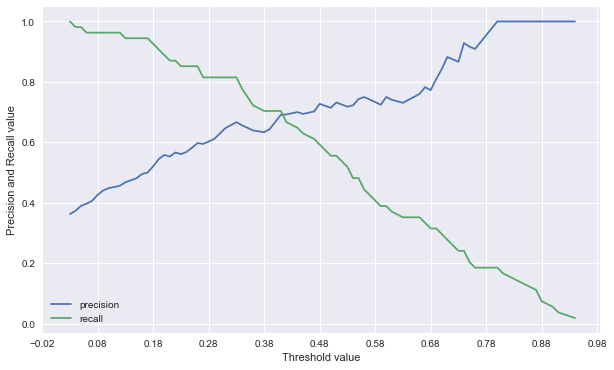

In [49]:
# 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
# 0.4 주변 값에서 재현율이 0.7후반정도로 예상되므로, 그 숫자를 기억해보겠다.

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def precision_recall_curve_plot(y_test , pred_proba_c1):
    plt.style.use('seaborn')
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(10,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.show()
    
precision_recall_curve_plot(y_test, rf_pred_proba)


In [50]:
# 임계값 변화에 따른 평가지표들
# 임계값이 0.3~0.35일 때 가장 좋아보인다. 
from sklearn.preprocessing import Binarizer

def get_clf_eval2(y_test, pred, pred_proba):
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print()

thresholds = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
rf_pred_proba_1 = rf_pred_proba.reshape(-1,1)

for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(rf_pred_proba_1) 
    custom_predict = binarizer.transform(rf_pred_proba_1)
    print('임계값:',custom_threshold)
    get_clf_eval2(y_test , custom_predict, rf_pred_proba_1)
    print()

임계값: 0.25
정확도: 0.7468, 정밀도: 0.5974, 재현율: 0.8519, F1: 0.7023, AUC:0.8393


임계값: 0.3
정확도: 0.7792, 정밀도: 0.6471, 재현율: 0.8148, F1: 0.7213, AUC:0.8393


임계값: 0.35
정확도: 0.7597, 정밀도: 0.6393, 재현율: 0.7222, F1: 0.6783, AUC:0.8393


임계값: 0.4
정확도: 0.7857, 정밀도: 0.6909, 재현율: 0.7037, F1: 0.6972, AUC:0.8393


임계값: 0.45
정확도: 0.7727, 정밀도: 0.7021, 재현율: 0.6111, F1: 0.6535, AUC:0.8393


임계값: 0.5
정확도: 0.7727, 정밀도: 0.7317, 재현율: 0.5556, F1: 0.6316, AUC:0.8393




[도전과제]
아래는 백화점 고객의 1년 간 구매 데이터이다.

(가) 제공 데이터 목록  
- y_train.csv : 고객의 성별 데이터 (학습용), CSV 형식의 파일
- X_train.csv, X_test.csv : 고객의 상품구매 속성 (학습용 및 평가용), CSV 형식의 파일  

(나) 데이터 형식 및 내용  
- y_train.csv (3,500명 데이터)
- X_train.csv (3,500명 데이터), X_test.csv (2,482명 데이터)

고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용하여 성별예측 모형을 만든 후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 다음과 같은 형식의 CSV 파일로 생성하시오.(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 채점)

custid,gender  
3500,0.267  
3501,0.578  
3502,0.885  
․ ․ ․  


성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, Feature Engineering, 분류 알고리즘 사용, 초매개변수 최적화, 모형 앙상블 등이 수반되어야 한다

1. 음수가 있으므로 정규화가 더 좋은..?
2. 훈련데이터 생성 시 학습이 되지 않는 카테고리가 있으면 안됨..
3. 

In [64]:
import pandas as pd
X_train = pd.read_csv('./dataset/X_train.csv',encoding='CP949')
df_test = pd.read_csv('./dataset/X_test.csv',encoding='CP949')
y_train = pd.read_csv('./dataset/y_train.csv',encoding='CP949')
X_train.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85


In [65]:
df_test.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,3500,70900400,22000000,4050000.0,골프,부산본점,13,1.461538,0.789474,26
1,3501,310533100,38558000,48034700.0,농산물,잠실점,90,2.433333,0.369863,3
2,3502,305264140,14825000,30521000.0,가공식품,본 점,101,14.623762,0.083277,3
3,3503,7594080,5225000,NaN,주방용품,부산본점,5,2.000000,0.000000,47
4,3504,1795790,1411200,NaN,수산품,청량리점,3,2.666667,0.125000,8


In [66]:
y_train.head()

,cust_id,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [67]:
df_train = X_train.merge(y_train,on='cust_id')
df_train.corr()

,cust_id,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기,gender
cust_id,1.000000,-0.008004,-0.005883,0.070135,-0.025234,-0.004840,0.001900,0.020070,-0.001994
총구매액,-0.008004,1.000000,0.700080,0.419734,0.659084,0.090022,0.014396,-0.212944,-0.150141
최대구매액,-0.005883,0.700080,1.000000,0.410562,0.374147,0.018980,0.022277,-0.115837,-0.114323
환불금액,0.070135,0.419734,0.410562,1.000000,0.270290,-0.063114,-0.062397,-0.211125,-0.078025
내점일수,-0.025234,0.659084,0.374147,0.270290,1.000000,0.225264,-0.010325,-0.293200,-0.155000
내점당구매건수,-0.004840,0.090022,0.018980,-0.063114,0.225264,1.000000,0.007659,-0.091151,-0.043917
주말방문비율,0.001900,0.014396,0.022277,-0.062397,-0.010325,0.007659,1.000000,0.003372,0.073598
구매주기,0.020070,-0.212944,-0.115837,-0.211125,-0.293200,-0.091151,0.003372,1.000000,0.041450
gender,-0.001994,-0.150141,-0.114323,-0.078025,-0.155000,-0.043917,0.073598,0.041450,1.000000


In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3500 non-null   int64  
 1   총구매액     3500 non-null   int64  
 2   최대구매액    3500 non-null   int64  
 3   환불금액     1205 non-null   float64
 4   주구매상품    3500 non-null   object 
 5   주구매지점    3500 non-null   object 
 6   내점일수     3500 non-null   int64  
 7   내점당구매건수  3500 non-null   float64
 8   주말방문비율   3500 non-null   float64
 9   구매주기     3500 non-null   int64  
 10  gender   3500 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 328.1+ KB


In [69]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2482 entries, 0 to 2481
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  2482 non-null   int64  
 1   총구매액     2482 non-null   int64  
 2   최대구매액    2482 non-null   int64  
 3   환불금액     871 non-null    float64
 4   주구매상품    2482 non-null   object 
 5   주구매지점    2482 non-null   object 
 6   내점일수     2482 non-null   int64  
 7   내점당구매건수  2482 non-null   float64
 8   주말방문비율   2482 non-null   float64
 9   구매주기     2482 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 194.0+ KB


In [70]:
df_train['환불금액'].min(), df_test['환불금액'].min()

(5600.0, 10000.0)

In [71]:
# 전처리 - 결측치 대체는 0으로 하는게 의미 있어 보임.. 환불금액이 없는것은 누락된 것보다 환불을 안한 것으로 간주하는게 타당
df_train['환불금액'] =df_train['환불금액'].fillna(0)
df_test['환불금액'] = df_test['환불금액'].fillna(0)

In [72]:
df_train['주구매상품'].unique()

array(['기타', '스포츠', '남성 캐주얼', '보석', '디자이너', '시티웨어', '명품', '농산물', '화장품',
       '골프', '구두', '가공식품', '수산품', '아동', '차/커피', '캐주얼', '섬유잡화', '육류',
       '축산가공', '젓갈/반찬', '액세서리', '피혁잡화', '일용잡화', '주방가전', '주방용품', '건강식품',
       '가구', '주류', '모피/피혁', '남성 트랜디', '셔츠', '남성정장', '생활잡화', '트래디셔널',
       '란제리/내의', '커리어', '침구/수예', '대형가전', '통신/컴퓨터', '식기', '소형가전', '악기'],
      dtype=object)

In [73]:
df_test['주구매상품'].unique()

array(['골프', '농산물', '가공식품', '주방용품', '수산품', '화장품', '기타', '스포츠', '디자이너',
       '시티웨어', '구두', '캐주얼', '명품', '건강식품', '남성정장', '커리어', '남성 캐주얼', '축산가공',
       '식기', '피혁잡화', '모피/피혁', '섬유잡화', '트래디셔널', '차/커피', '육류', '가구', '아동',
       '셔츠', '액세서리', '젓갈/반찬', '대형가전', '일용잡화', '통신/컴퓨터', '생활잡화', '주방가전',
       '란제리/내의', '남성 트랜디', '보석', '주류', '침구/수예', '악기'], dtype=object)

In [74]:
# 주구매상품이 맞지 않음. 훈련용 데이터에만 있는 것은 오히려 모델에 안좋은 영향일 수 있음
# 2건이니, 그냥 삭제토록 함
len(df_train['주구매상품'].unique()), len(df_test['주구매상품'].unique())

(42, 41)

In [75]:
df_train.drop(df_train[df_train['주구매상품']=='소형가전'].index, inplace=True)

In [76]:
# 훈련데이터의 남녀 비율을 확인. 이러면 남자의 데이터를 훈련 못하는게 아닐까..?
# 오버샘플링까지 필요한가는 더 생각해 보아야 함.
df_train[df_train.gender == 1].shape[0],df_train[df_train.gender == 0].shape[0]

(1315, 2183)

In [77]:
grouped = df_train[['gender','주구매상품']].groupby('주구매상품')
grouped.mean() > 0.75

,gender
주구매상품,
가공식품,False
가구,False
건강식품,False
골프,False
구두,False
기타,False
남성 캐주얼,True
남성 트랜디,False
남성정장,True


In [78]:
grouped.mean()

,gender
주구매상품,
가공식품,0.419414
가구,0.500000
건강식품,0.531915
골프,0.536585
구두,0.518519
기타,0.369748
남성 캐주얼,0.763636
남성 트랜디,0.500000
남성정장,0.818182


In [79]:
grouped.count()

,gender
주구매상품,
가공식품,546
가구,10
건강식품,47
골프,82
구두,54
기타,595
남성 캐주얼,55
남성 트랜디,2
남성정장,22


In [80]:
grouped = df_train[['gender','주구매상품']].groupby('주구매상품')
grouped.mean() < 0.25

,gender
주구매상품,
가공식품,False
가구,False
건강식품,False
골프,False
구두,False
기타,False
남성 캐주얼,False
남성 트랜디,False
남성정장,False


In [81]:
# 주구매상품을 남성이 많이 사는 것과 여성이 많이 사는 것으로 나눠보고,
# 여성이 많이 사는 것 F, 남성이 많이 사는 것 M, 모르겠는 것 E로 둔다.
# 이 방법은 잠정적으로 폐지함. 너무 과대적합하게 하는 요소가 아닐까 생각이 들었기 때문. 대신, 몇개만 묶어서 두는 것으로 

# import numpy as np
# pro_dict = {'F':['보석','농산물','화장품','가공식품','수산품','차/커피','육류','축산가공','젓갈/반찬','액세서리','일용잡화','주방가전','주방용품','란제리/내의'],
#             'M':['스포츠','남성 캐주얼','골프','구두','남성 트랜디','셔츠','남성정장','주류','통신/컴퓨터'],
#             'E':['기타','디자이너','시티웨어','명품','아동','캐주얼','섬유잡화','피혁잡화','건강식품','가구','모피/피혁','생활잡화','트래디셔널','란제리/내의','커리어','침구/수예','대형가전','식기','악기']}
# def pro_class(x):
#     for key, value in pro_dict.items():
#         for i in value:
#             if  x == i:
#                 return key
#     return np.nan
# # 위의 함수를 적용하여 name 피처를 새롭게 정의합니다.
# df_train['주구매상품'] = df_train['주구매상품'].apply(lambda x: pro_class(x))
# X_test['주구매상품'] = X_test['주구매상품'].apply(lambda x: pro_class(x))
# print(df_train['주구매상품'].value_counts())

In [82]:
for i in ['남성 캐주얼','남성정장','악기','주류']:
    df_train.주구매상품[df_train.주구매상품 == i] = '남성용품'
    df_test.주구매상품[df_test.주구매상품 == i] = '남성용품'
for i in ['디자이너','시티웨어','액세서리','참구/수예']:
    df_train.주구매상품[df_train.주구매상품 == i] = '여성용품'
    df_test.주구매상품[df_test.주구매상품 == i] = '여성용품'

In [83]:
df_train.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,2,3197000,1639000,0.0,남성용품,관악점,2,2.000000,0.000000,1,1
3,3,16077620,4935000,0.0,기타,광주점,18,2.444444,0.318182,16,1
4,4,29050000,24000000,0.0,보석,본 점,2,1.500000,0.000000,85,0


In [84]:
y_train = df_train['gender']
df_train = df_train.drop(['cust_id','gender'],axis=1)
df_test_custid = df_test['cust_id']
df_test.drop('cust_id',axis=1,inplace=True)

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in ['총구매액','최대구매액','환불금액','내점일수','내점당구매건수','주말방문비율','구매주기']:
    scaled = scaler.fit_transform(df_train[i].values.reshape(-1,1))
    scaled2 = scaler.fit_transform(df_test[i].values.reshape(-1,1))
    df_train[i] = scaled
    df_test[i] = scaled2
pre_df = pd.get_dummies(df_train)
pre_df_test = pd.get_dummies(df_test)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pre_df, y_train, test_size = 0.3, random_state = 11, stratify = y_train)

In [87]:
display(X_train.head())

,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기,주구매상품_가공식품,주구매상품_가구,주구매상품_건강식품,...,주구매지점_안양점,주구매지점_영등포점,주구매지점_울산점,주구매지점_인천점,주구매지점_일산점,주구매지점_잠실점,주구매지점_전주점,주구매지점_창원점,주구매지점_청량리점,주구매지점_포항점
1662,-0.562273,-0.614323,-0.275514,-0.672086,0.085761,-1.060884,-0.847381,1,0,0,...,0,0,0,0,0,0,0,0,0,0
574,2.255393,0.943585,-0.255783,1.241415,0.154834,1.207181,-0.604929,0,0,0,...,1,0,0,0,0,0,0,0,0,0
220,-0.459268,-0.280412,-0.187656,-0.193711,0.197827,0.167246,0.122428,0,0,0,...,0,0,0,0,0,0,0,0,0,0
817,2.143161,0.286890,-0.275514,0.689444,-0.781276,-0.044967,-0.483703,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3367,-0.560876,-0.607165,-0.275514,-0.672086,-0.437213,-1.060884,-0.847381,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [88]:
# 분류 모델별 예측 수행, 검증까지
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# # auc 평가 함수
def get_clf_eval(y_train, pred_proba):
#     accuracy = accuracy_score(y_test , pred)
#     precision = precision_score(y_test , pred)
#     recall = recall_score(y_test , pred)
#     f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_train, pred_proba)
    print('AUC:{0:.4f}'.format(roc_auc))
    print()

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(max_leaf_nodes=15, random_state=11)
rf_clf = RandomForestClassifier(n_estimators= 100, max_leaf_nodes=35, random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred_proba = dt_clf.predict_proba(X_train)[:, 1]
print('DecisionTreeClassifier')
get_clf_eval(y_train,dt_pred_proba)

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred_proba = rf_clf.predict_proba(X_train)[:, 1]
print('RandomForestClassifier')
get_clf_eval(y_train,rf_pred_proba)

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred_proba = lr_clf.predict_proba(X_train)[:, 1]
print('LogisticRegression')
get_clf_eval(y_train,lr_pred_proba)

DecisionTreeClassifier
AUC:0.6838

RandomForestClassifier
AUC:0.7921

LogisticRegression
AUC:0.7038



In [24]:
# 하이퍼 파라미터 최적화
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[5,10,12,15,18,20],
             'min_samples_split':[2,3,5,7], 'min_samples_leaf':[8,12,15]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters , scoring='roc_auc' , cv=5)
grid_dclf.fit(X_train , y_train)

grid_rclf = GridSearchCV(rf_clf, param_grid=parameters , scoring='roc_auc' , cv=5)
grid_rclf.fit(X_train,y_train)
# print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
# print('GridSearchCV 최고 roc_auc스코어: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_
best_rclf = grid_rclf.best_estimator_

prob_d = best_dclf.predict_proba(X_test)[:,1]
prob_r = best_rclf.predict_proba(X_test)[:,1]
roc_auc_d = roc_auc_score(y_test,prob_d)
roc_auc_r = roc_auc_score(y_test,prob_r)
print(f'dt: {roc_auc_d}')
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
print(f'rf : {roc_auc_r}')
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rclf.best_score_))

dt: 0.6474712532611847
GridSearchCV 최고 정확도: 0.6368
rf : 0.6949908203691179
GridSearchCV 최고 정확도: 0.6754


In [93]:
pred_proba_result = pd.DataFrame(grid_rclf.predict_proba(pre_df_test))
# 컬럼 이름이 1로 되어 있어서 그렇게 뽑음
result = pd.concat([df_test_custid,pred_proba_result[[1]]],axis=1)
result

,cust_id,1
0,3500,0.392561
1,3501,0.213593
2,3502,0.196043
3,3503,0.347918
4,3504,0.371314
...,...,...
2477,5977,0.433629
2478,5978,0.406504
2479,5979,0.446907
2480,5980,0.370378


In [98]:
result.columns = [['cust_id','gender']]
result

,cust_id,gender
0,3500,0.392561
1,3501,0.213593
2,3502,0.196043
3,3503,0.347918
4,3504,0.371314
...,...,...
2477,5977,0.433629
2478,5978,0.406504
2479,5979,0.446907
2480,5980,0.370378


In [108]:
result.gender.count()

gender    2482
dtype: int64

In [107]:
result.gender[result.gender >= 0.5].count()

gender    73
dtype: int64

In [27]:
result.to_csv('result.csv',index=False)

In [28]:
pd.read_csv('result.csv')

,cust_id,gender
0,3500,0.392561
1,3501,0.213593
2,3502,0.196043
3,3503,0.347918
4,3504,0.371314
...,...,...
2477,5977,0.433629
2478,5978,0.406504
2479,5979,0.446907
2480,5980,0.370378
